# Pivot Tables

Hemos visto cómo la abstracción ``GroupBy`` nos permite explorar las relaciones dentro de un conjunto de datos.
Una *pivot tables* es una operación similar que suele verse en hojas de cálculo y otros programas que operan con datos tabulares.
La tabla pivotante toma como entrada datos simples ordenados por columnas y agrupa las entradas en una tabla bidimensional que proporciona un resumen multidimensional de los datos.

Para los ejemplos de esta sección, utilizaremos la base de datos de pasajeros del *Titanic*, disponible a través de la biblioteca Seaborn.

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [79]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Contiene abundante información sobre cada pasajero de aquel malogrado viaje: sexo, edad, clase, precio del boleto y mucho más.

## Pivot Tables a mano

Para empezar a aprender más sobre estos datos, podríamos empezar agrupando según el sexo, el estado de supervivencia o alguna combinación de los mismos.
Es posible que sienta la tentación de aplicar una operación ``GroupBy``; por ejemplo, veamos la tasa de supervivencia por sexo:

In [104]:
titanic.groupby('class',observed=False)[['age']].mean()

,age
class,
First,38.233441
Second,29.877630
Third,25.140620


In [80]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


Esto nos da inmediatamente una idea: en general, tres de cada cuatro mujeres a bordo sobrevivieron, ¡mientras que sólo uno de cada cinco hombres sobrevivió!

Esto es útil, pero podríamos ir un paso más allá y analizar la supervivencia por sexo y, digamos, por clase.
Usando el vocabulario de ``GroupBy``, podríamos proceder de esta manera:
agrupamos por clase y sexo, seleccionamos la supervivencia, aplicamos un agregado medio, combinamos los grupos resultantes, y luego descomponemos el índice jerárquico para revelar la multidimensionalidad oculta.

In [81]:
titanic.groupby(['sex', 'class'], observed=False)['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Esto nos da una mejor idea de cómo el género y la clase afectan a la supervivencia, pero el código empieza a parecer un poco confuso.
Aunque cada paso de este proceso tiene sentido a la luz de las herramientas que hemos discutido anteriormente, la larga cadena de código no es particularmente fácil de leer o utilizar.
Este ``GroupBy`` bidimensional es lo suficientemente común como para que Pandas incluya una rutina de conveniencia, ``pivot_table``, que maneja sucintamente este tipo de agregación multidimensional.

## Sintaxis de las Pivot Table 

Aquí tienes el equivalente a la operación anterior utilizando el método ``pivot_table`` de ``DataFrame``:

In [82]:
titanic.pivot_table('survived', index='sex', columns='class', observed=False)

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Este método es mucho más legible que el enfoque "group by" y produce el mismo resultado.
Como cabría esperar de un crucero transatlántico de principios del siglo XX, el gradiente de supervivencia favorece tanto a las mujeres como a las clases más altas.
Las mujeres de primera clase sobrevivieron con casi total seguridad, mientras que sólo uno de cada diez hombres de tercera clase sobrevivió.

### Pivot Tables Multi-nivel

Al igual que en ``GroupBy``, la agrupación en las tablas pivotes puede especificarse con múltiples niveles, y mediante una serie de opciones.
Por ejemplo, podríamos estar interesados en ver la edad como una tercera dimensión.
Agruparemos la edad utilizando la función ``pd.cut``:

In [83]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class', observed=False)

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

También podemos aplicar la misma estrategia al trabajar con las columnas; añadamos información sobre la tarifa pagada utilizando ``pd.qcut`` para calcular automáticamente los cuantiles:

In [84]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'], observed=False)

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

### Opciones adicionales de Pivot Tables

La firma completa del método ``pivot_table`` de ``DataFrame`` es la siguiente:

```python
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```

Ya hemos visto ejemplos de los tres primeros argumentos; aquí echaremos un vistazo rápido a los restantes.
Dos de las opciones, ``fill_value`` y ``dropna``, tienen que ver con los datos que faltan y son bastante sencillas; no mostraremos ejemplos de ellas aquí.

La palabra clave ``aggfunc`` controla qué tipo de agregación se aplica, que por defecto es una media.

Como en GroupBy, la especificación de la agregación puede ser una cadena que represente una de las opciones más comunes (por ejemplo, ``sum``, ``mean``, ``count``, ``min``, ``max``, etc.) o una función que implemente una agregación (por ejemplo, ``np.sum()``, ``min()``, ``sum()``, etc.).

Además, se puede especificar como un diccionario que asigna una columna a cualquiera de las opciones deseadas anteriores:

In [85]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived': 'sum', 'fare': 'mean'}, observed=False)


fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Observa también aquí que hemos omitido la palabra clave ``values``; al especificar una asignación para ``aggfunc``, ésta se determina automáticamente.

A veces es útil calcular totales a lo largo de cada agrupación.
Esto puede hacerse mediante la palabra clave ``margins``:

In [86]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True, observed=False)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


Aquí esto nos da automáticamente información sobre la tasa de supervivencia agnóstica por género, la tasa de supervivencia agnóstica por género por clase, y la tasa de supervivencia global del 38%.

La etiqueta del margen se puede especificar con la palabra clave ``margins_name``, que por defecto es ``"All"``.

## Ejemplo: Datos de natalidad

Como ejemplo más interesante, veamos los datos de libre acceso sobre nacimientos en Estados Unidos, proporcionados por los Centros para el Control de Enfermedades (CDC).
Estos datos pueden consultarse en https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [87]:
# comando shell para descargar los datos:
!curl -o data/births.csv https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  258k  100  258k    0     0   746k      0 --:--:-- --:--:-- --:--:--  764k


In [88]:
births = pd.read_csv('data/births.csv')
births

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548
...,...,...,...,...,...
15542,2008,10,NaN,M,183219
15543,2008,11,NaN,F,158939
15544,2008,11,NaN,M,165468
15545,2008,12,NaN,F,173215


Si echamos un vistazo a los datos, vemos que son relativamente sencillos: contienen el número de nacimientos agrupados por fecha y sexo:

Podemos empezar a entender estos datos un poco mejor utilizando una tabla dinámica.
Añadamos una columna de década y veamos los nacimientos de hombres y mujeres en función de la década:

In [89]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


Inmediatamente vemos que los nacimientos masculinos superan a los femeninos en cada década.
Para ver esta tendencia un poco más claramente, podemos utilizar las herramientas de trazado incorporadas en Pandas para visualizar el número total de nacimientos por año.

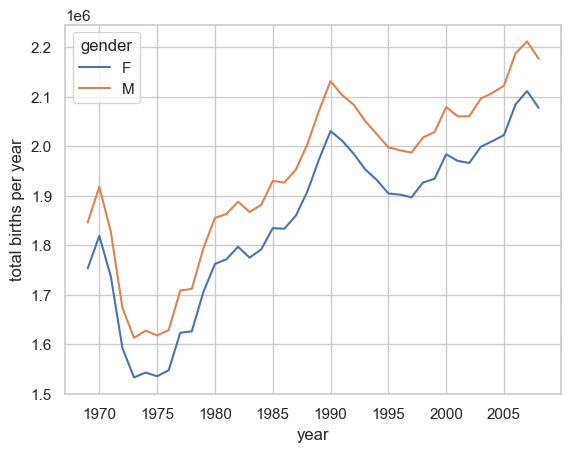

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

Con una simple tabla dinámica y el método ``plot()``, podemos ver inmediatamente la tendencia anual de los nacimientos por sexo. A simple vista, parece que en los últimos 50 años los nacimientos masculinos han superado a los femeninos en un 5% aproximadamente.

### Mayor exploración de datos

Aunque esto no está necesariamente relacionado con la pivot table, hay algunas características más interesantes que podemos extraer de este conjunto de datos utilizando las herramientas de Pandas que hemos visto hasta ahora.
Debemos empezar por limpiar un poco los datos, eliminando los valores atípicos causados por fechas mal escritas (por ejemplo, 31 de junio) o valores que faltan (por ejemplo, 99 de junio).
Una forma sencilla de eliminarlos todos a la vez es cortar los valores atípicos; lo haremos mediante una operación robusta de recorte sigma:

In [94]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

Esta línea final es una estimación robusta de la media muestral, donde el 0,74 procede del rango intercuartílico de una distribución gaussiana.

Con esto podemos utilizar el método ``query()`` para filtrar las filas con nacimientos fuera de estos valores:

In [95]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

A continuación, cambiamos la columna ``day`` a números enteros; antes era una cadena porque algunas columnas del conjunto de datos contenían el valor ``'null'``:

In [96]:
# cambiar la columna 'day' a entero; originalmente era una cadena debido a los nulos
births['day'] = births['day'].astype(int)

C:\Users\Abdon.RAMIREZ-BRICEN\AppData\Local\Temp\ipykernel_20996\2085529121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  births['day'] = births['day'].astype(int)


Por último, podemos combinar el día, el mes y el año para crear un índice Fecha.

Esto nos permite calcular rápidamente el día de la semana correspondiente a cada fila:

In [97]:
# crear un índice datetime a partir del año, mes, día
births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')

births['dayofweek'] = births.index.dayofweek

C:\Users\Abdon.RAMIREZ-BRICEN\AppData\Local\Temp\ipykernel_20996\1958084001.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  births['dayofweek'] = births.index.dayofweek


De este modo, podemos trazar los nacimientos por día de la semana durante varias décadas:

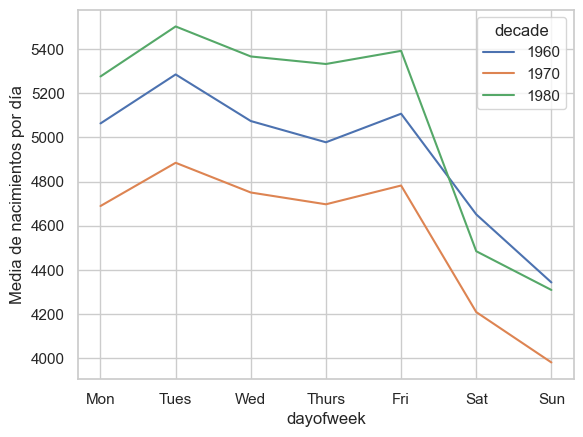

In [98]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek', columns='decade', aggfunc='mean').plot()
ax = plt.gca()

ax.set_xticks(range(7))
ax.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

plt.ylabel('Media de nacimientos por día')
plt.show()


Al parecer, los nacimientos son ligeramente menos frecuentes los fines de semana que entre semana. Nótese que faltan los años 90 y 2000 porque los datos de los CDC sólo contienen el mes de nacimiento a partir de 1989.

Otra visión interesante es representar el número medio de nacimientos por día del *año*.
Agrupemos primero los datos por mes y día por separado:

In [99]:
births_by_date = births.pivot_table('births', 
                                    [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

El resultado es un multiíndice de meses y días.
Para que sea más fácil de trazar, convirtamos estos meses y días en una fecha asociándolos a una variable de año ficticia (¡asegurándonos de elegir un año bisiesto para que el 29 de febrero se trate correctamente!)

In [100]:
births_by_date.index = [pd.Timestamp(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


Centrándonos sólo en el mes y el día, ahora tenemos una serie temporal que refleja el número medio de nacimientos por fecha del año.
A partir de aquí, podemos utilizar el método ``plot`` para representar gráficamente los datos. Esto revela algunas tendencias interesantes:

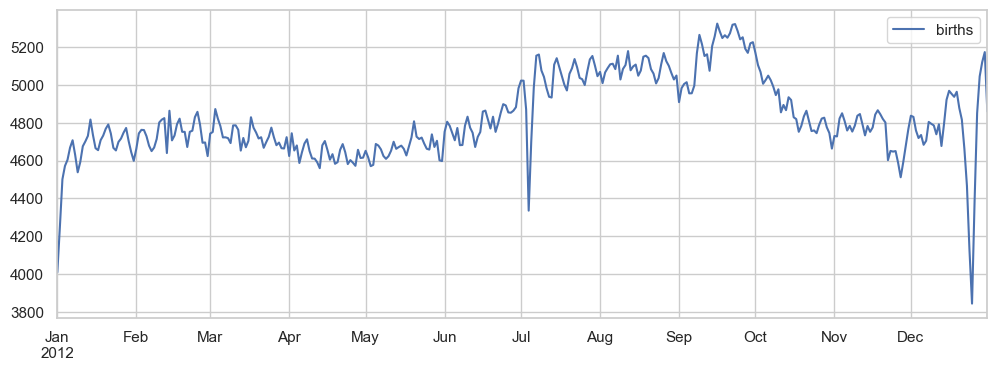

In [101]:
# Trazar los resultados
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

En concreto, lo más llamativo de este gráfico es la caída de la natalidad en los días festivos de EE.UU. (por ejemplo, el Día de la Independencia, el Día del Trabajo, Acción de Gracias, Navidad, Año Nuevo), aunque es probable que esto refleje tendencias en los nacimientos programados/inducidos más que algún profundo efecto psicosomático sobre los nacimientos naturales.

Si observamos este breve ejemplo, veremos que muchas de las herramientas de Python y Pandas que hemos visto hasta ahora pueden combinarse y utilizarse para obtener información de una gran variedad de conjuntos de datos.

<!--NAVIGATION-->
< [Agregación y agrupación](7-Agregaciones_y_agrupaciones.ipynb) | [Trabajar con string](9-Trabajar_con_string.ipynb) >